# Automatic Extraction of Fine Structural Information in ARPES by Multi-Stage Clustering Algorithm

Lingzhu Bian, Chen Liu, Zhen Zhang, Yingke Huang, Xinyu Pan, Yi Zhang, Jiaou Wang, Zhesheng Chen, Yuhui Dong  

Correspondence should be addressed to Lingzhu Bian (bianlz@ihep.ac.cn)

## Reference-based Auto-correlation Clustering

 ### - Module Setting

In [1]:
import warnings
import os
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score
import math
warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '8'
np.set_printoptions(threshold=np.inf)
from scipy import signal

### - Plot Setting

In [2]:
col_arr = ["gray","orange","brown","blue","purple", "violet"]
fontsize1=40
fontsize2=35
markershape="o"
markersize=25
plt.rcParams['font.family'] = 'Times New Roman'

### - Load data and initial settings

In [3]:
file = h5py.File("RealData.h5", 'r')
dataset = file['data'] 
original_mapdata = dataset[:] 

# Size
xn = np.shape(original_mapdata)[0] # x-axis  
yn = np.shape(original_mapdata)[1] # y-axis
en = np.shape(original_mapdata)[2] # Energies
an = np.shape(original_mapdata)[3] # Angles
pn = xn * yn

# X axis
x_ini = 75
x_end = 165
xw = x_end-x_ini # Width 
dx = 1 # Step

# Y axis
y_ini = 175
y_end = 256
yw =y_end-y_ini  # Width
dy = 1.0125 # Step

# Mapping axes will be rescaled w.r.t. center of the image
k = 0
xpos = np.zeros(xn*yn)
ypos = np.zeros(xn*yn)
for i in range(xn):
    for j in range(yn):
        xpos[k] = -xw/2 + i*dx 
        ypos[k] = -yw/2 + j*dy 
        k += 1
    
# Energy/Angle axis
eng_ini = 84.9599
eng_end = 99.9160
engbins = 889

ang_ini = -20.0431     
ang_end = 6.6810
angbins = 32

eng = np.zeros(engbins)
for i in range(engbins):
    eng[i]=eng_ini+(eng_end-eng_ini)/(engbins-1)*i
ang = np.zeros(angbins)
for i in range(angbins):
    ang[i]=ang_ini+(ang_end-ang_ini)/(angbins-1)*i



print("Load File:", "MBN.h5")
print("\r")
print("---Data Size---")
print("Map Axis 1 :", xn)
print("Map Axis 2 :", yn)
print("Energy :", en)
print("Angle :", an)
print("Energy (start, end):", eng_ini, eng_end)
print("Angle (start, end):", ang_ini, ang_end)
print("eng:", eng)
print("ang:", ang)
print("\r")

Load File: MBN.h5

---Data Size---
Map Axis 1 : 91
Map Axis 2 : 81
Energy : 889
Angle : 32
Energy (start, end): 84.9599 99.916
Angle (start, end): -20.0431 6.681
eng: [84.9599     84.97674245 84.99358491 85.01042736 85.02726982 85.04411227
 85.06095473 85.07779718 85.09463964 85.11148209 85.12832455 85.145167
 85.16200946 85.17885191 85.19569437 85.21253682 85.22937928 85.24622173
 85.26306419 85.27990664 85.2967491  85.31359155 85.33043401 85.34727646
 85.36411892 85.38096137 85.39780383 85.41464628 85.43148874 85.44833119
 85.46517365 85.4820161  85.49885856 85.51570101 85.53254347 85.54938592
 85.56622838 85.58307083 85.59991329 85.61675574 85.6335982  85.65044065
 85.66728311 85.68412556 85.70096802 85.71781047 85.73465293 85.75149538
 85.76833784 85.78518029 85.80202275 85.8188652  85.83570766 85.85255011
 85.86939257 85.88623502 85.90307748 85.91991993 85.93676239 85.95360484
 85.9704473  85.98728975 86.00413221 86.02097466 86.03781712 86.05465957
 86.07150203 86.08834448 86.1051

### - Spatial map of total ARPES intensity 

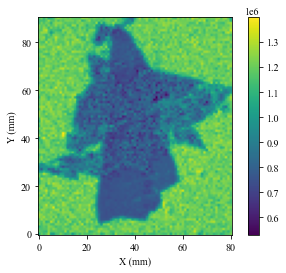

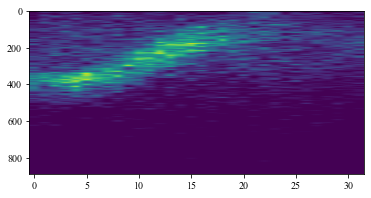

In [4]:
tot_map = np.sum(np.sum(original_mapdata, axis = 3), axis = 2)
# plot image
plt.imshow(tot_map, origin='lower')
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.show()

ARPES = np.array(original_mapdata)[15][40]
# plot image
fig, ax = plt.subplots()
ax.imshow(ARPES, aspect = 0.0175)
plt.show()

### - Truth Table

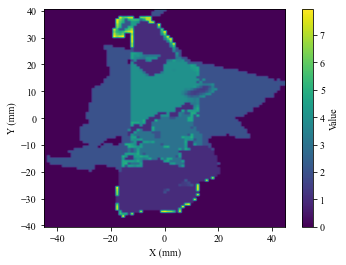

In [5]:
file_TT = h5py.File("truth_table.h5", 'r')
dataset_TT = file_TT['s2']  
TruthTable = dataset_TT[:]  
TruthTable = np.where(TruthTable == 2, 1, np.where(TruthTable == 1, 2, TruthTable))

fig, ax = plt.subplots()
im = ax.imshow(TruthTable, extent = [-xw/2, xw/2, -yw/2, yw/2], origin='lower')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')

cbar = plt.colorbar(im)
cbar.set_label('Value')
plt.show()

### - Self-defined functions for calculating performance metrics and plotting

In [6]:
#Calculate Accuracy, Precision, Recall and F1
def calculate_metrics(nk, comment, TruthTable, km_results):
    filename = "metrics_correlations.txt"
    with open(filename, "a") as file:  # Use "a" mode to append to the file
        if comment is None:
            file.write("nk = {}".format(nk) + "\n")  # Add a new line after each output
        elif nk is None:
            file.write(comment + "\n")  # Add a new line after each output

    # Overall Accuracy
    equal_elements = TruthTable == km_results.reshape(91,81)
    similarity_rate = np.mean(equal_elements)
    print("Overall Accuracy: ", similarity_rate)
    output_text = "Overall Accuracy: {}".format(similarity_rate)
    with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output
    
    sample = ["Au", "MoS2-Au", "BN", "1-MoS2", "m-MoS2"]
    for i in range(len(sample)):
        sample_TruthTable = np.where(TruthTable == i, 1, 0)
        sample_prediction = np.where(km_results.reshape(91,81) == i, 1, 0)

        TP = np.sum((sample_TruthTable == 1) & (sample_prediction == 1))
        FN = np.sum((sample_TruthTable == 1) & (sample_prediction == 0))
        FP = np.sum((sample_TruthTable == 0) & (sample_prediction == 1))
        TN = np.sum((sample_TruthTable == 0) & (sample_prediction == 0))

        if TP+FN+FP+TN != 0:
            Accuracy = (TP+TN)/(TP+FN+FP+TN)
        else:
            Accuracy = 0

        if TP+FP != 0:
            Precision = TP/(TP+FP)
        else:
            Precision = 0

        if TP+FN != 0:
            Recall = TP/(TP+FN)
        else:
            Recall = 0

        if Precision + Recall != 0:
            F1 = 2 * Precision * Recall / (Precision + Recall)
        else:
            F1 = 0

        print("Accuracy, Precision, Recall and F1 of {}: ".format(sample[i]), Accuracy, Precision, Recall, F1)
        output_text = "Accuracy, Precision, Recall and F1 of {}: {}, {}, {}, {}".format(sample[i], Accuracy, Precision, Recall, F1)
        with open(filename, "a") as file:  # Use "a" mode to append to the file
            file.write(output_text + "\n")  # Add a new line after each output

In [7]:
# Obtain the index chosen 
def get_location_in_iARPESArray_from_iARPESRange(ang_left,ang_right,eng_left,eng_right,ang,eng):
    arr = np.array(ang)
    condition = arr < ang_left
    if not np.any(condition):
        LR_col = 0
    else:
        indexes = np.where(condition)
        LR_col = indexes[0][-1]

    condition = arr > ang_right
    if not np.any(condition):
        RR_col = len(ang)-1
    else:
        indexes = np.where(condition)
        RR_col = indexes[0][0]
   
    arr = np.array(eng)
    condition = arr < eng_left
    if not np.any(condition):
        LR_row = 0
    else:
        indexes = np.where(condition)
        LR_row = indexes[0][-1]

    condition = arr > eng_right
    if not np.any(condition):
        RR_row = len(eng)-1
    else:
        indexes = np.where(condition)
        RR_row = indexes[0][0]
    
    #print("The range of angle is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(ang[LR_col],LR_col,ang[RR_col],RR_col,LR_col+1,ang[LR_col+1],RR_col-1,ang[RR_col-1]))
    #print("The range of energy is [%f(%d),%f(%d)], the value of bin %d is %f and bin %d is %f"%(eng[LR_row],LR_row,eng[RR_row],RR_row,LR_row+1,eng[LR_row+1],RR_row-1,eng[RR_row-1]))
    
    return LR_col,RR_col,LR_row,RR_row

In [8]:
def correlations_plot(correlation_results):
    correlation_results = np.array(correlation_results).reshape(91, 81)
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(correlation_results.T, extent = [-xw/2, xw/2, -yw/2, yw/2], origin='lower', aspect = 1)
    ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_title(f"{material} as the reference", fontsize=fontsize1, fontname='Times New Roman')
    cbar = plt.colorbar(im)
    plt.show()
    
    return fig

In [9]:
def clustering_plot(nk, km_results):
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1, 1, 1)    
    for i in range(nk):
        x = []
        y = []
        for j in range(pn):
            curcln = km_results[j]
            if i == curcln:
                x = np.append(x, xpos[j])
                y = np.append(y, ypos[j])
            if j == pn-1:
                ax.scatter(x, y, marker=markershape, s=markersize, c = col_arr[i], label=str(i+1))

    ax.set_xlim(-xw/2, xw/2)  
    ax.set_ylim(-yw/2, yw/2)  
    ax.tick_params(axis='both', which='major', labelsize=fontsize1) 
    ax.set_xlabel('X (mm)', fontsize=fontsize1, fontname='Times New Roman')
    ax.set_ylabel('Y (mm)', fontsize=fontsize1, fontname='Times New Roman')
    #ax.set_title(f"{material}({posx},{posy})", loc="left", fontsize=fontsize1, fontname='Times New Roman')

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels, loc='upper right',bbox_to_anchor=(1,1.1),ncol=nk+1)  
    i = 0
    for text in legend.get_texts():
        text.set_fontsize(fontsize2)
        text.set_fontname('Times New Roman')
        text.set_color(col_arr[i])
        i = i+1
    i = 0
    for handle in legend.legendHandles:
        handle.set_color(col_arr[i])  
        handle.set_sizes([600])   
        i = i+1
    plt.show()
    
    return fig

### - Only analyse the mapdata in range eng [92,96] and ang [-15,5] 
#### - These are adjustable parameters

In [10]:
LR_col,RR_col,LR_row,RR_row = get_location_in_iARPESArray_from_iARPESRange(-15, 5, 92, 96, ang, eng)
mapdata = original_mapdata[:,:,LR_row:RR_row+1, LR_col:RR_col+1]

### - Spatial map of total ARPES intensity with the window above

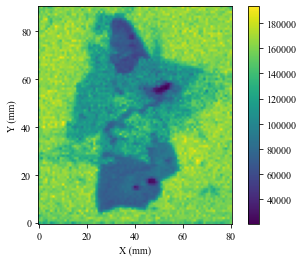

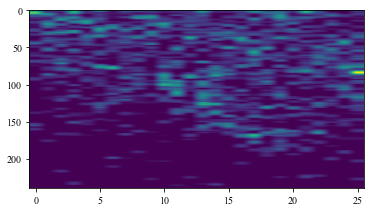

In [11]:
tot_map = np.sum(np.sum(mapdata, axis = 3), axis = 2)
# plot image
plt.imshow(tot_map, origin='lower')
plt.colorbar()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.show()

ARPES = np.array(mapdata)[55][40]

# plot image
fig, ax = plt.subplots()
ax.imshow(ARPES, aspect = 0.0575)
plt.show()

## Part 1:  2D image of Au  with coordinates (10,10) as reference picture

In [12]:
material = "Au"
posx = 10
posy = 10

### - Main body and plotting

Elapsed Time:  0.7195820808410645


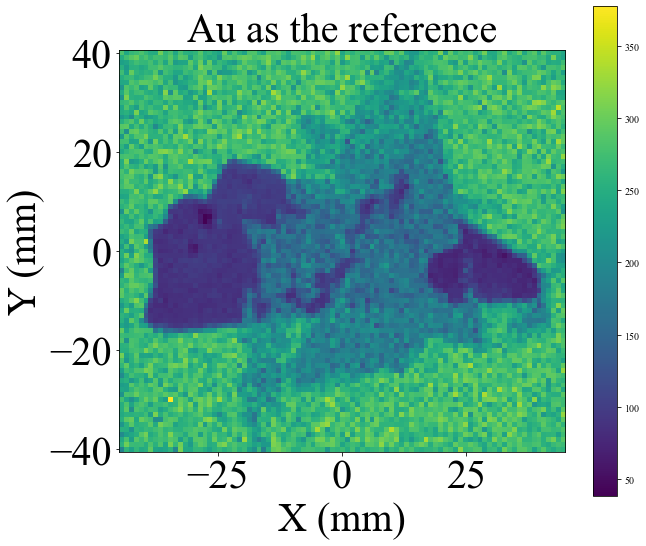

In [13]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

### - K-means clustering with the input of correlation numbers
#### - SSE curve

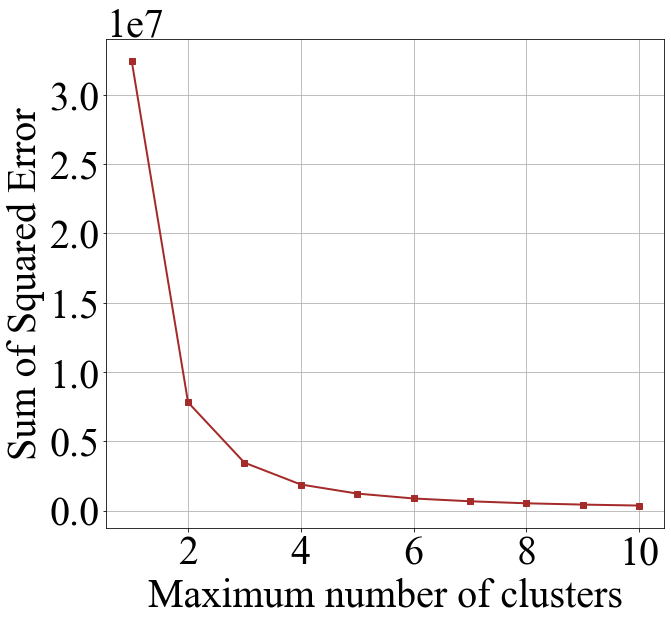

In [14]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 2

Overall Accuracy:  0.6860670194003528
Accuracy, Precision, Recall and F1 of Au:  0.9000135666802334 0.8529171766625867 0.9961877531570169 0.9190020881415539
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.7838827838827839 0.35479951397326853 1.0 0.5237668161434977
Accuracy, Precision, Recall and F1 of BN:  0.8247184913851581 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


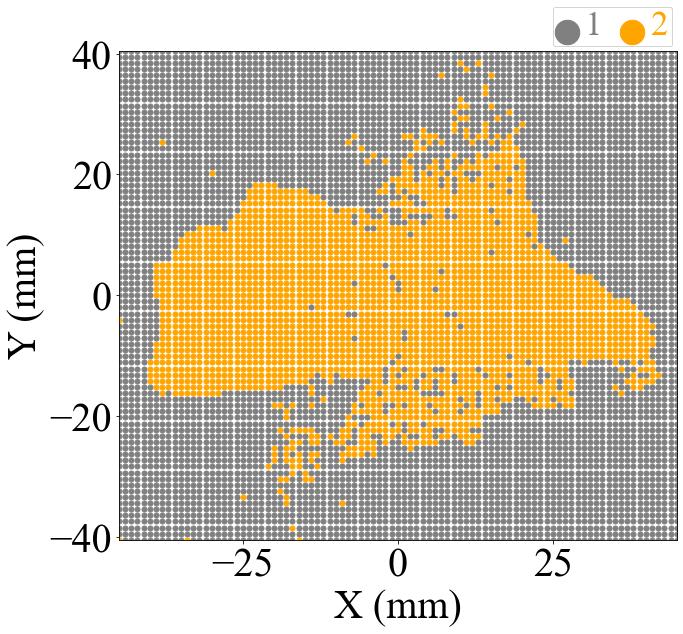

In [15]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy), TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 3

Overall Accuracy:  0.7978564645231312
Accuracy, Precision, Recall and F1 of Au:  0.9367792701126034 0.941747572815534 0.9475816059089827 0.9446555819477436
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9555012888346222 0.7349914236706689 0.978310502283105 0.8393731635651321
Accuracy, Precision, Recall and F1 of BN:  0.8399131732465066 0.5282542885973764 0.8103715170278638 0.6395846059865608
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


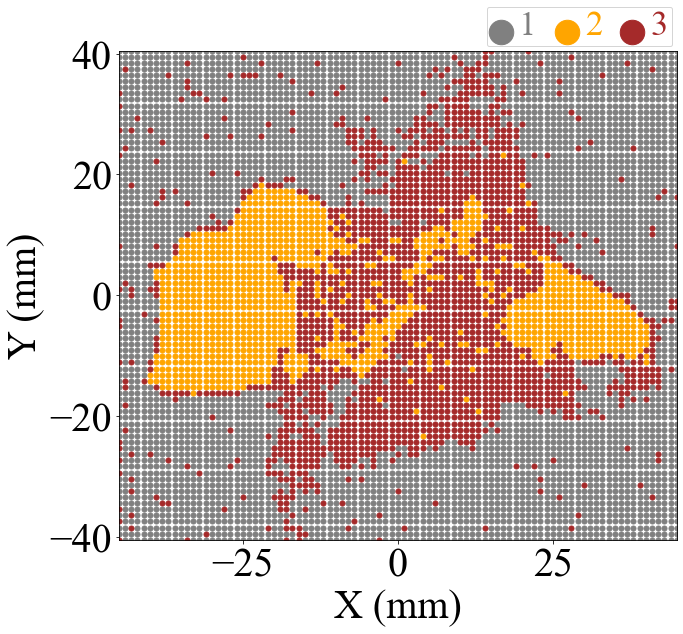

In [16]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 2: 2, 1: 1}
km_results = np.array([label_mapping[label] for label in km_results])
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 4

Overall Accuracy:  0.5563695563695563
Accuracy, Precision, Recall and F1 of Au:  0.7747931081264414 0.990715667311412 0.6101977603049797 0.7552344441167796
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9645909645909646 0.7849860982391103 0.9668949771689498 0.8664961636828644
Accuracy, Precision, Recall and F1 of BN:  0.6643603310269977 0.22096317280453256 0.3622291021671827 0.27448680351906163
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.8107448107448108 0.14159848961611077 0.87890625 0.24390243902439024
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


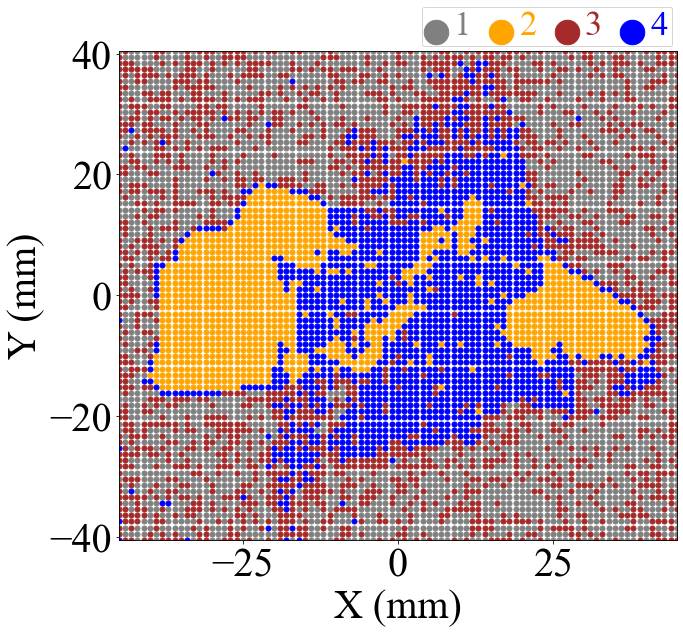

In [17]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 2: 3, 3: 0, 1:2}
km_results = np.array([label_mapping[label] for label in km_results])
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

#### - Spatial Distribution of clusters and performance metrics of n = 5

Overall Accuracy:  0.5090218423551757
Accuracy, Precision, Recall and F1 of Au:  0.6716863383530051 0.9070087036188731 0.47176554681915656 0.6206896551724138
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9721883055216388 0.8331678252234359 0.9577625570776256 0.8911311736590547
Accuracy, Precision, Recall and F1 of BN:  0.8614841948175281 0.6177237185056472 0.5503095975232198 0.5820712239050349
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.8769502102835436 0.20273972602739726 0.8671875 0.3286454478164323
Accuracy, Precision, Recall and F1 of m-MoS2:  0.6837606837606838 0.0 0.0 0


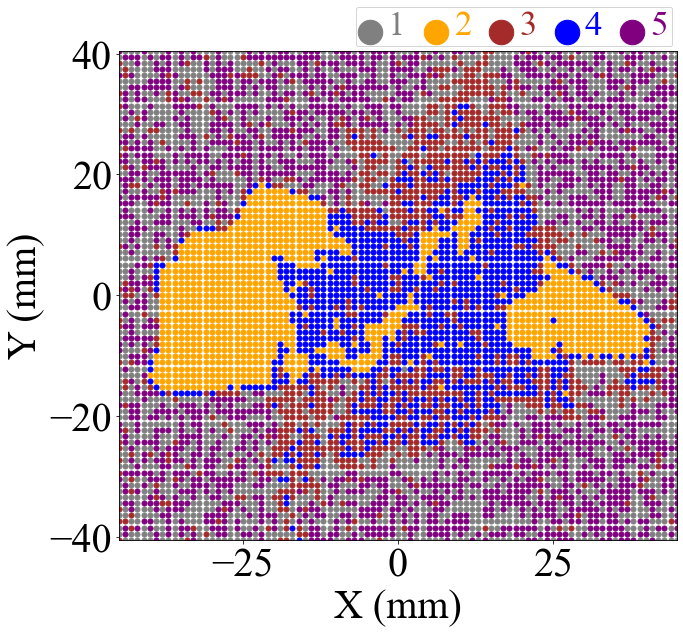

In [18]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0:0, 1: 3, 2:1, 3:2, 4:4}
km_results = np.array([label_mapping[label] for label in km_results])
## metrics of performance     
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 2: 2D image of BN  with coordinates (15,40) as reference picture

In [19]:
material = "BN"
posx = 15
posy = 40

Elapsed Time:  0.7382698059082031


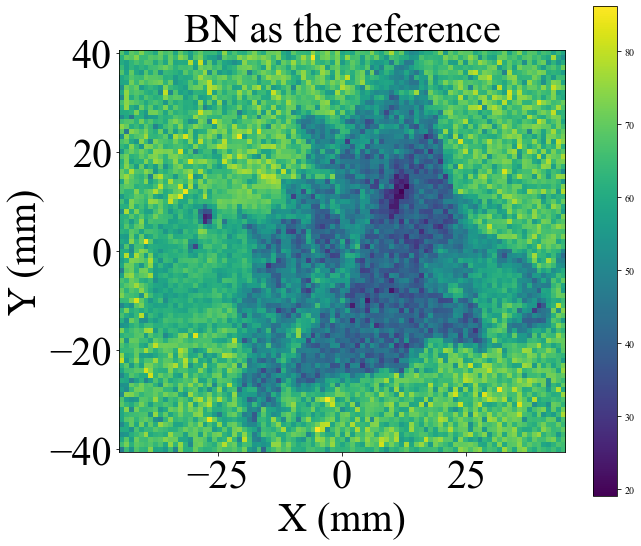

In [20]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

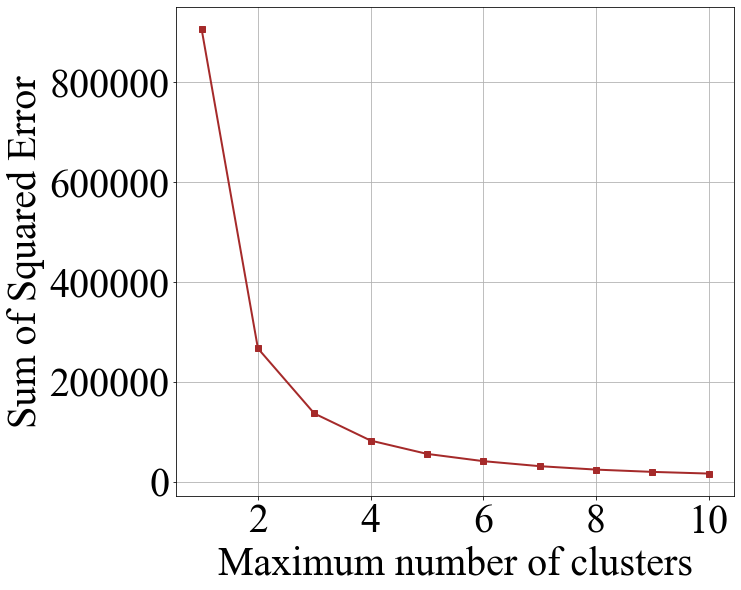

In [21]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5704789038122371
Accuracy, Precision, Recall and F1 of Au:  0.8370641703975037 0.8003207698476343 0.9511555873242793 0.8692433315187807
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.6156559489892823 0.08938313050776332 0.24315068493150685 0.1307149432341209
Accuracy, Precision, Recall and F1 of BN:  0.8247184913851581 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


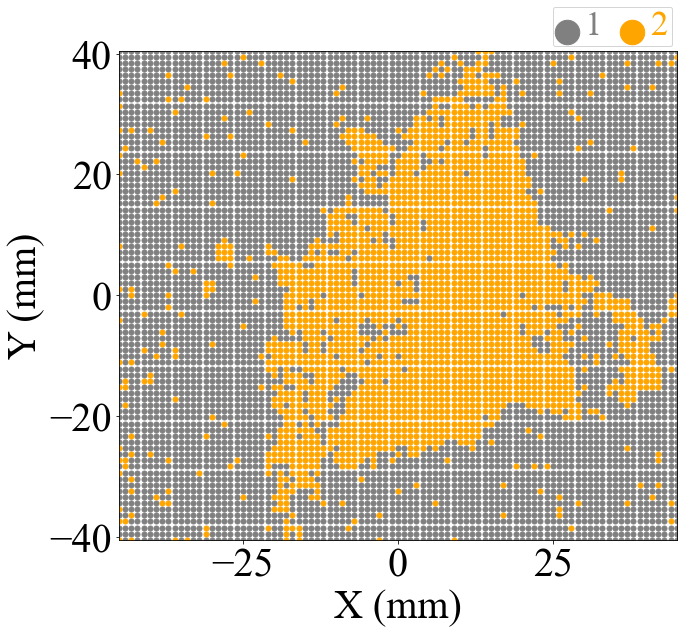

In [22]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5437525437525438
Accuracy, Precision, Recall and F1 of Au:  0.7454890788224121 0.9099258212645708 0.6137717417202764 0.7330677290836654
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.6547279880613214 0.20334162815499468 0.6529680365296804 0.31011114123068584
Accuracy, Precision, Recall and F1 of BN:  0.8237688237688238 0.49797336421540245 0.6656346749226006 0.5697250745279895
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


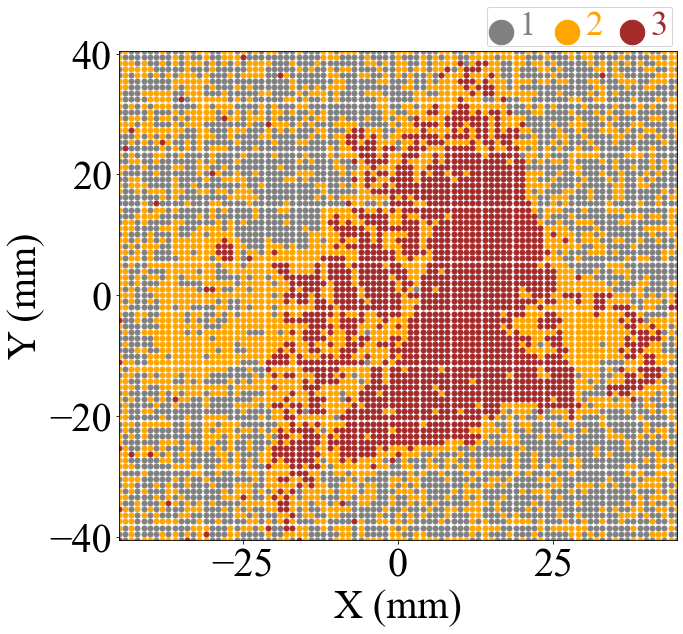

In [23]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 1: 2, 2: 1}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.3918057251390585
Accuracy, Precision, Recall and F1 of Au:  0.6514719848053181 0.9366952789699571 0.41601143674052893 0.5761425507342023
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.6406186406186406 0.17657789128055454 0.5525114155251142 0.2676251036770804
Accuracy, Precision, Recall and F1 of BN:  0.8184778184778185 0.48013816925734026 0.43034055727554177 0.45387755102040817
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.7747931081264414 0.06343283582089553 0.3984375 0.10944206008583691
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


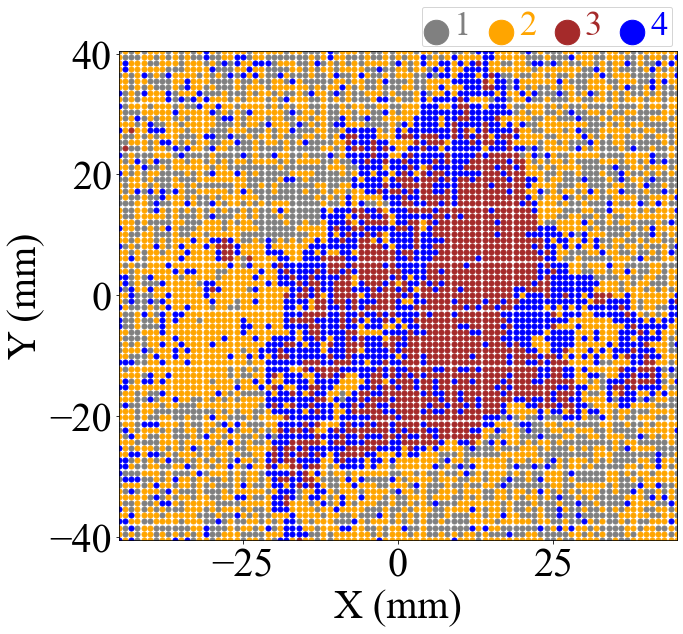

In [24]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {3: 1,1:2,2:0,0:3}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.2934472934472934
Accuracy, Precision, Recall and F1 of Au:  0.5934065934065934 0.9484304932735426 0.3023588277340958 0.4585365853658536
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.7513227513227513 0.22164048865619546 0.4349315068493151 0.29364161849710985
Accuracy, Precision, Recall and F1 of BN:  0.8131868131868132 0.4513172966781214 0.30495356037151705 0.363972286374134
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.8298738298738298 0.09562398703403566 0.4609375 0.15838926174496645
Accuracy, Precision, Recall and F1 of m-MoS2:  0.6471306471306472 0.00045310376076121433 0.0025252525252525255 0.000768344218209758


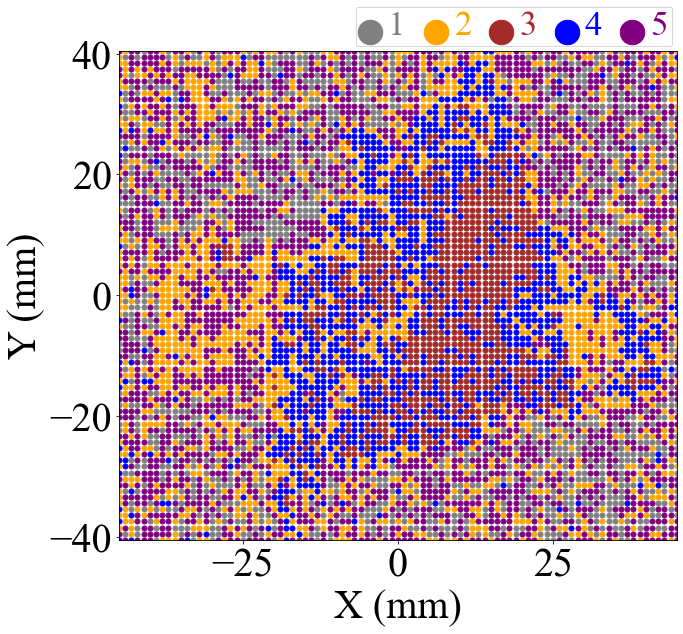

In [25]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0:1,1:3,3:2,2:0,4:4}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 3: 2D image of mono-MoS2  with coordinates (35,40) as reference picture

In [26]:
material = "1-MoS2"
posx = 35
posy = 40

Elapsed Time:  0.74072265625


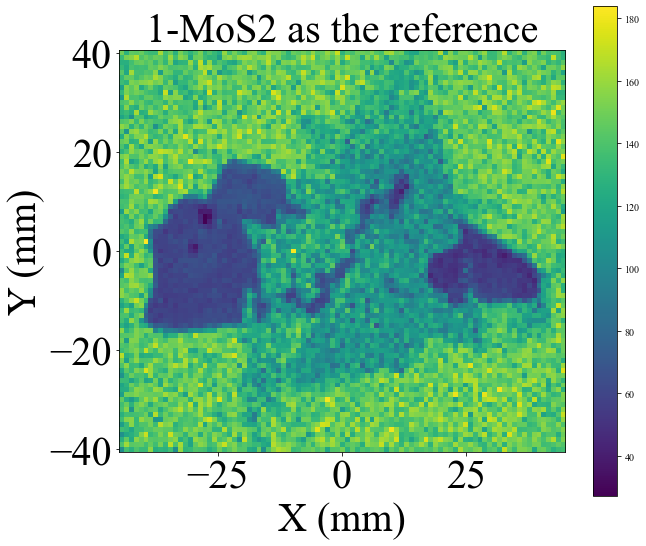

In [27]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

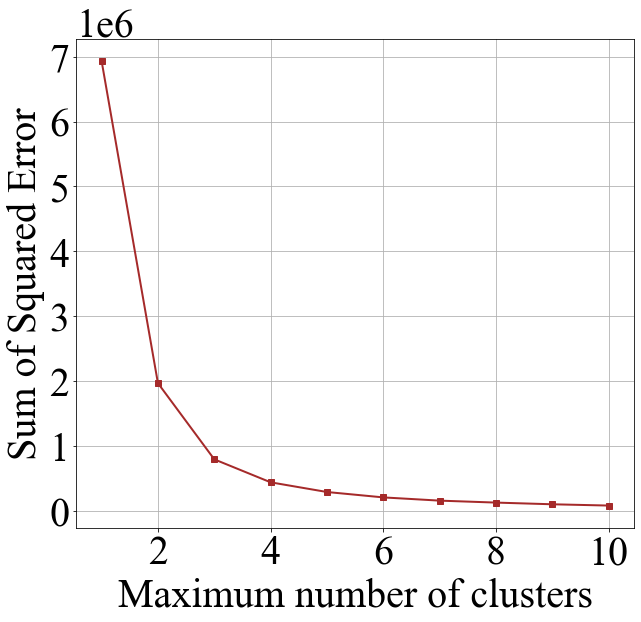

In [28]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.6852530185863519
Accuracy, Precision, Recall and F1 of Au:  0.818070818070818 0.759825327510917 0.9949964260185847 0.8616527390900651
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.8641975308641975 0.4666666666666667 0.9988584474885844 0.6361323155216285
Accuracy, Precision, Recall and F1 of BN:  0.8247184913851581 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


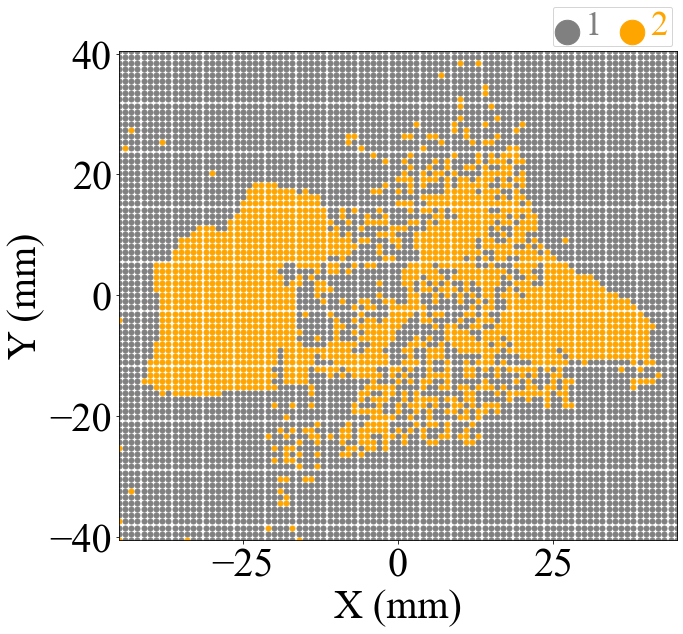

In [29]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 1: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7391127391127391
Accuracy, Precision, Recall and F1 of Au:  0.873015873015873 0.928515111695138 0.841791756016202 0.8830292426893277
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9625559625559625 0.7659574468085106 0.9863013698630136 0.8622754491017964
Accuracy, Precision, Recall and F1 of BN:  0.7791344458011125 0.4310910582444627 0.8134674922600619 0.5635388739946381
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


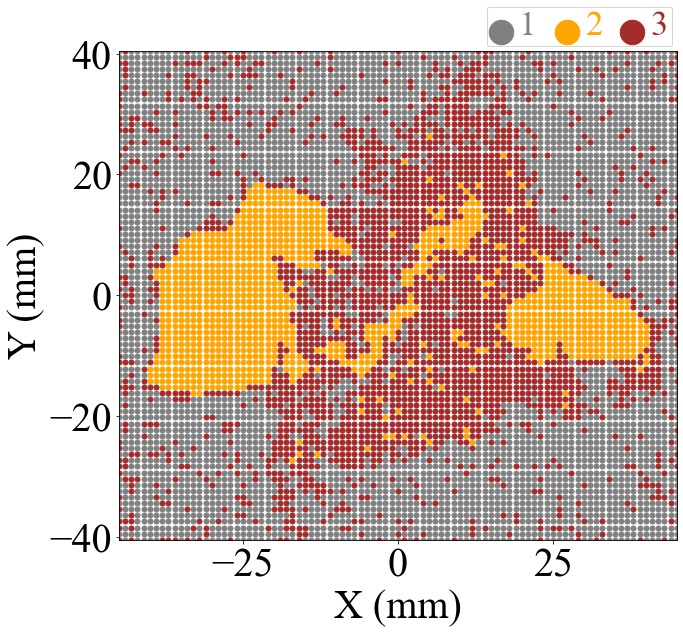

In [30]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 2, 1: 0, 2: 1}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5520282186948854
Accuracy, Precision, Recall and F1 of Au:  0.7442680776014109 0.9741591468416735 0.5658803907553014 0.7159005275056518
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9728666395333062 0.8287937743190662 0.9726027397260274 0.8949579831932774
Accuracy, Precision, Recall and F1 of BN:  0.8214624881291548 0.4918144611186903 0.5580495356037152 0.5228426395939086
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.6672093338760006 0.04961049610496105 0.47265625 0.08979591836734695
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


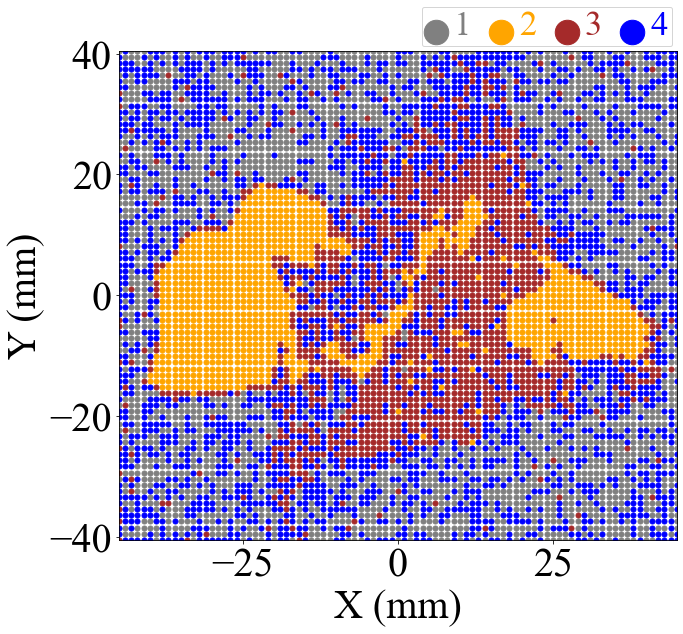

In [31]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 1: 2, 2: 1, 3:3}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.45963912630579296
Accuracy, Precision, Recall and F1 of Au:  0.6605616605616605 0.8829643018526887 0.465570645699309 0.6096723868954759
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9754443087776421 0.8564102564102564 0.9531963470319634 0.9022150189086979
Accuracy, Precision, Recall and F1 of BN:  0.8182064848731515 0.47520661157024796 0.3560371517027864 0.40707964601769914
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.7882241215574549 0.0872865275142315 0.5390625 0.15024496461622208
Accuracy, Precision, Recall and F1 of m-MoS2:  0.7248677248677249 0.0006119951040391676 0.0025252525252525255 0.0009852216748768472


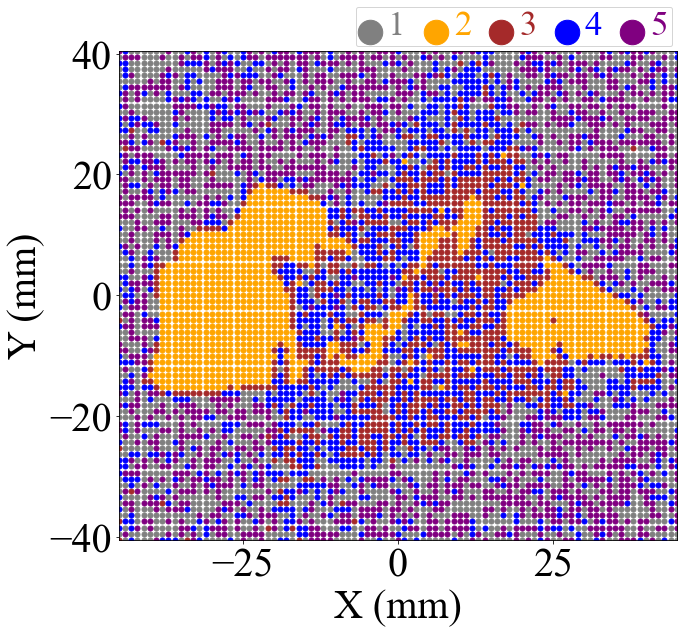

In [32]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 0, 1: 1, 2: 2, 3:3, 4:4}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 4: 2D image of multi-MoS2  with coordinates (55,40) as reference picture

In [33]:
material = "m-MoS2"
posx = 55
posy = 40

Elapsed Time:  0.7469160556793213


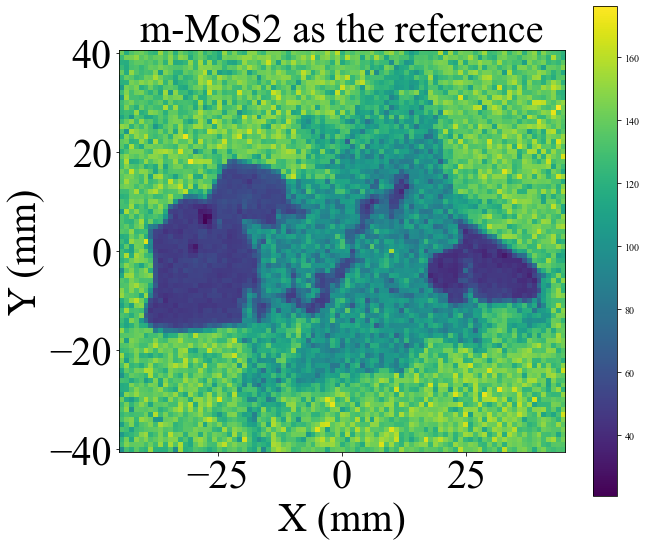

In [34]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        correlation_result = signal.correlate2d(np.divide(mapdata[posx,posy],np.max(mapdata[posx,posy])), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time) 

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

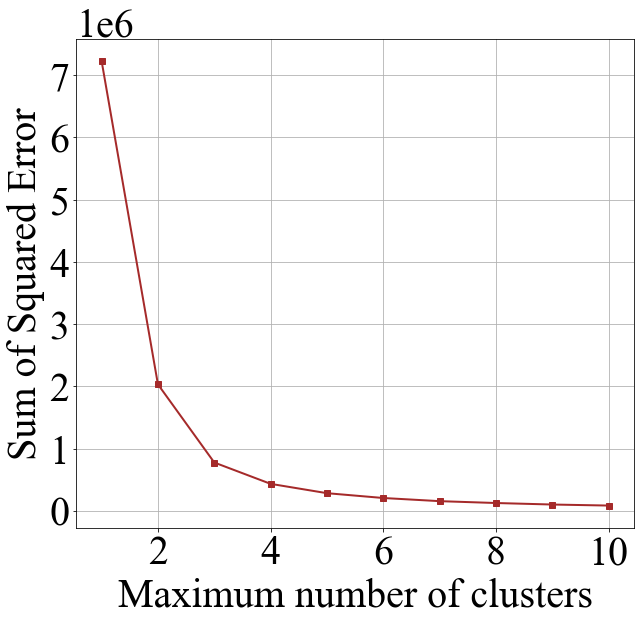

In [35]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_{posx}_{posy}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.6860670194003528
Accuracy, Precision, Recall and F1 of Au:  0.838013838013838 0.7801828699384213 0.9961877531570169 0.8750523231477606
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.8458825125491792 0.43538767395626243 1.0 0.6066481994459835
Accuracy, Precision, Recall and F1 of BN:  0.8247184913851581 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


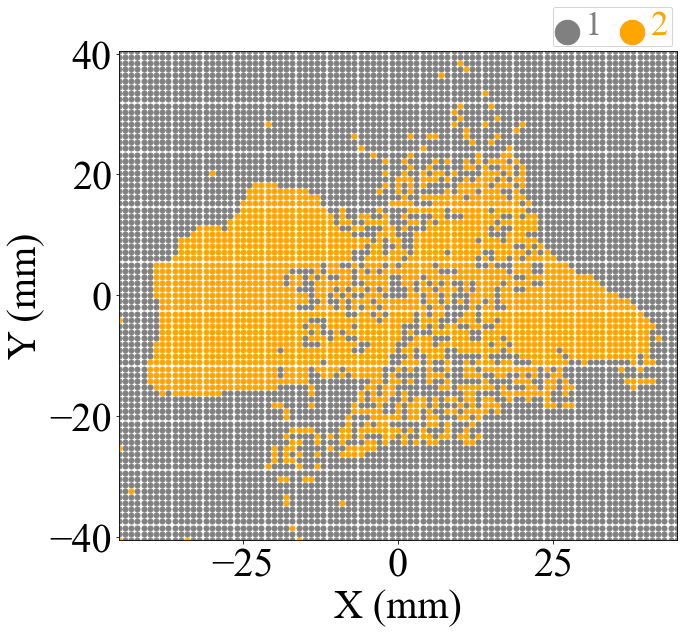

In [36]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 1: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7644824311490979
Accuracy, Precision, Recall and F1 of Au:  0.9015059015059015 0.936823559023408 0.8868239218489398 0.9111383108935129
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9664902998236331 0.7866909753874203 0.9851598173515982 0.8748099341104916
Accuracy, Precision, Recall and F1 of BN:  0.7974494641161308 0.45632333767926986 0.8126934984520123 0.584469802393543
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


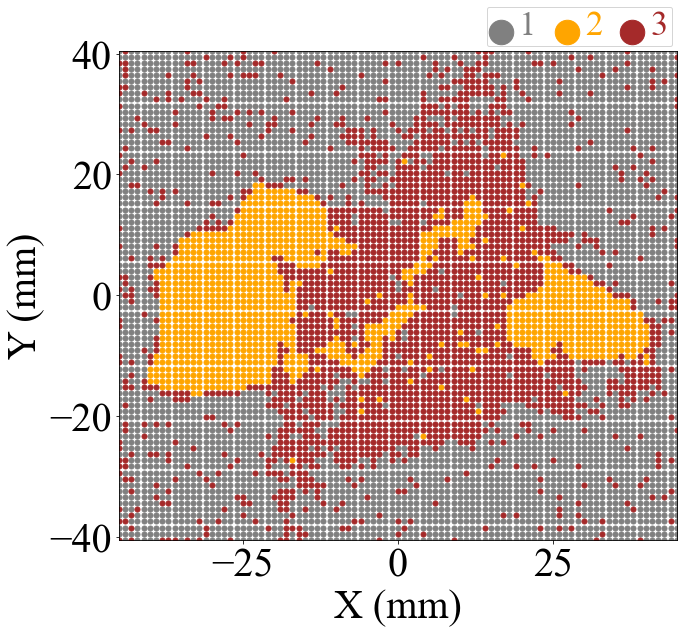

In [37]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1: 1, 2: 2, 0: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5605752272418939
Accuracy, Precision, Recall and F1 of Au:  0.7686881020214353 0.9807098765432098 0.6056707171789374 0.7488584474885845
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9732736399403066 0.8305744888023369 0.973744292237443 0.8964792433000525
Accuracy, Precision, Recall and F1 of BN:  0.6617826617826618 0.234174413457282 0.40944272445820434 0.29794424105885664
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.8191561524894858 0.13931681178834562 0.8125 0.23785020011435107
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


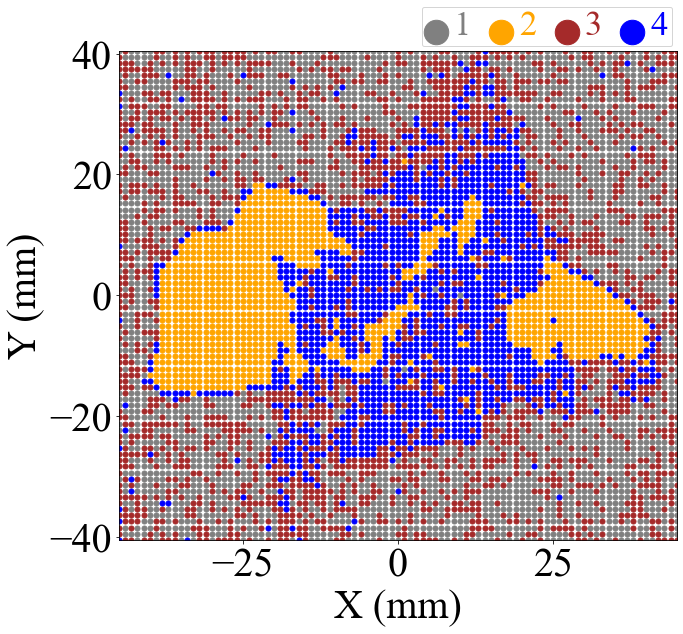

In [38]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1:1,3:3,0:0,2:2}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.4647944647944648
Accuracy, Precision, Recall and F1 of Au:  0.6688373355040022 0.9932584269662922 0.4212532761496307 0.5916011376944955
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9763939763939764 0.8574338085539714 0.9611872146118722 0.906350914962325
Accuracy, Precision, Recall and F1 of BN:  0.8110161443494777 0.46431095406360423 0.5085139318885449 0.4854082009604728
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.8704382037715371 0.14944834503510532 0.58203125 0.237829209896249
Accuracy, Precision, Recall and F1 of m-MoS2:  0.6509293175959843 0.004551661356395084 0.025252525252525252 0.007713073659853451


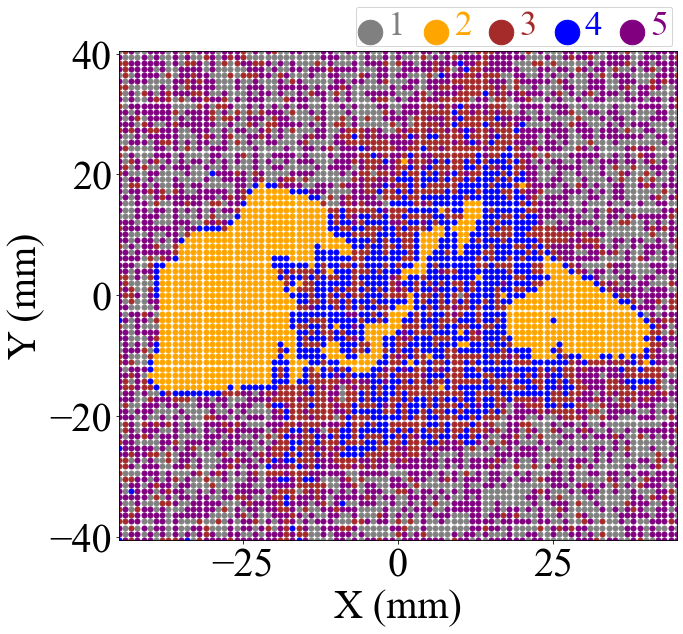

In [39]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1:1, 3:3, 0:2, 2:0, 4:4}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, {}({},{}) as the reference: ".format(nk,material, posx, posy) , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_{posx}_{posy}_nk{nk}.svg', dpi=300, bbox_inches='tight')

## Part 5: 2D image of mono-MoS2  with Fig4o(ii) in the paper as reference picture

In [40]:
material = "standard 1-MoS2"

In [41]:
reference_monoMoS2 = np.load("reference_1600_field3_target1_nk4_2.npy")

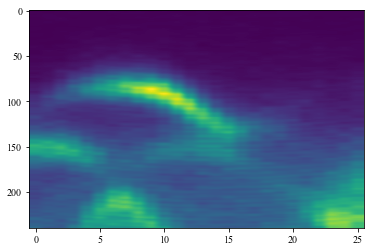

In [42]:
plt.imshow(reference_monoMoS2, aspect="auto")
reference_monoMoS2 = reference_monoMoS2[232:472,1:27]
plt.imshow(reference_monoMoS2, aspect="auto")

Elapsed Time:  0.854642391204834


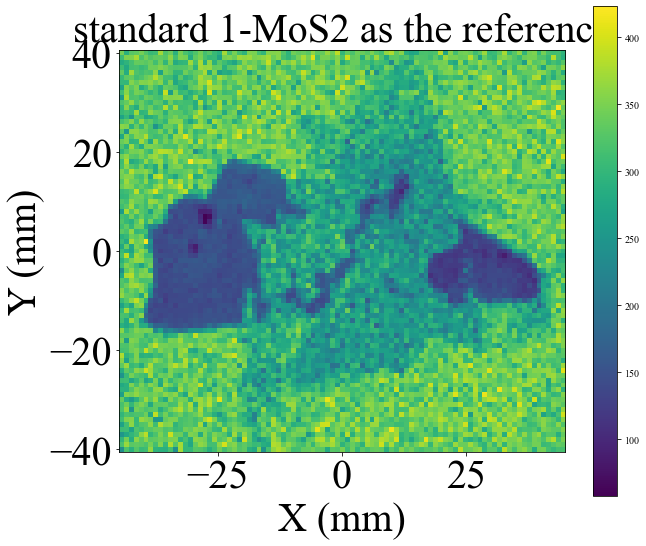

In [43]:
t1 = time.time()
correlation_results = []
for i in range(mapdata.shape[0]):
    for j in range(mapdata.shape[1]):
        mapdata[i,j] = np.flip(mapdata[i,j])
        correlation_result = signal.correlate2d(np.divide(reference_monoMoS2,np.max(reference_monoMoS2)), np.divide(mapdata[i, j],np.max(mapdata[i,j])),mode = "valid")
        correlation_results.append(correlation_result)
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)  

fig = correlations_plot(correlation_results)
fig.savefig(f'plots_correlations/correlations_reference.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/correlations_reference.svg', dpi=300, bbox_inches='tight')

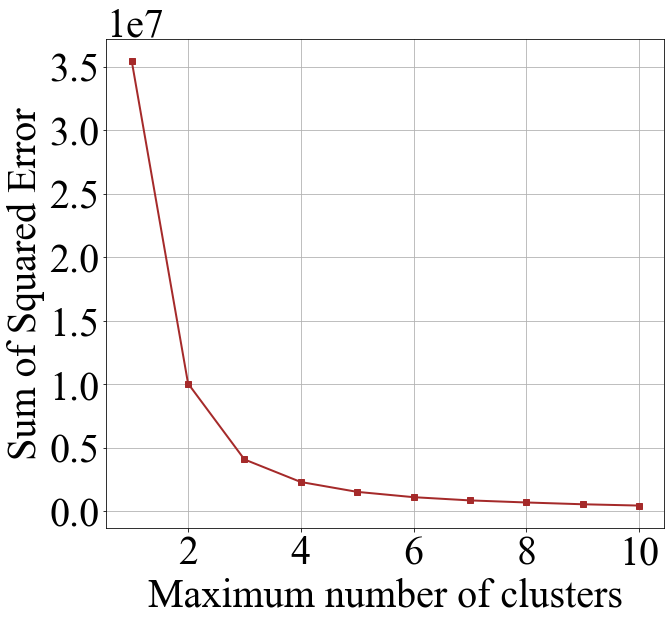

In [44]:
targetMap = np.array(correlation_results).reshape(-1, 1)

max_nk = 10
sse = np.zeros(max_nk)
xsse = np.zeros(max_nk)

for i in range(max_nk):
    curnk = i + 1 
    km = KMeans(n_clusters=curnk, init='random', n_init=10, max_iter=100, random_state=0)
    km_model = km.fit(targetMap)
    sse[i] = km_model.inertia_ 
    xsse[i] = curnk

fig = plt.figure(figsize=(10,9))
plt.plot(xsse, sse, marker='s', color='brown',linewidth=2)
plt.grid(True)
plt.xlabel('Maximum number of clusters',fontsize=fontsize1)
plt.ylabel('Sum of Squared Error',fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.yticks(fontsize=fontsize1)

ax=plt.gca()
ax.yaxis.get_offset_text().set_fontsize(fontsize1)
plt.show()
fig.savefig(f'plots_correlations/initialSSE_reference.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/initialSSE_reference.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.6851173517840184
Accuracy, Precision, Recall and F1 of Au:  0.8114231447564781 0.753202237055746 0.9947581605908983 0.8572895277207392
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.8705738705738706 0.4786652078774617 0.9988584474885844 0.6471893491124261
Accuracy, Precision, Recall and F1 of BN:  0.8247184913851581 0 0.0 0
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


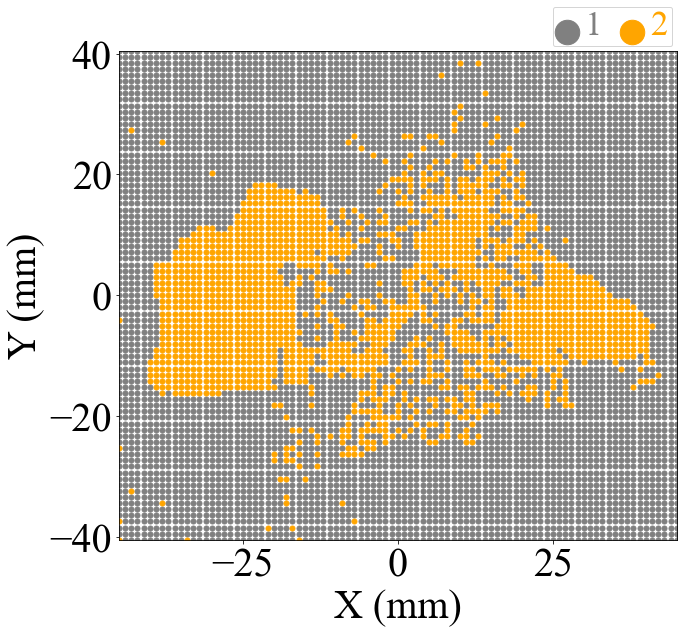

In [45]:
nk=2
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 1: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.7300230633563967
Accuracy, Precision, Recall and F1 of Au:  0.8673178673178673 0.9339444594230251 0.8253514415058375 0.8762964836832785
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9584859584859585 0.7452667814113597 0.9885844748858448 0.8498527968596664
Accuracy, Precision, Recall and F1 of BN:  0.7707231040564374 0.4204 0.8134674922600619 0.5543248945147679
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.9652692986026319 0 0.0 0
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


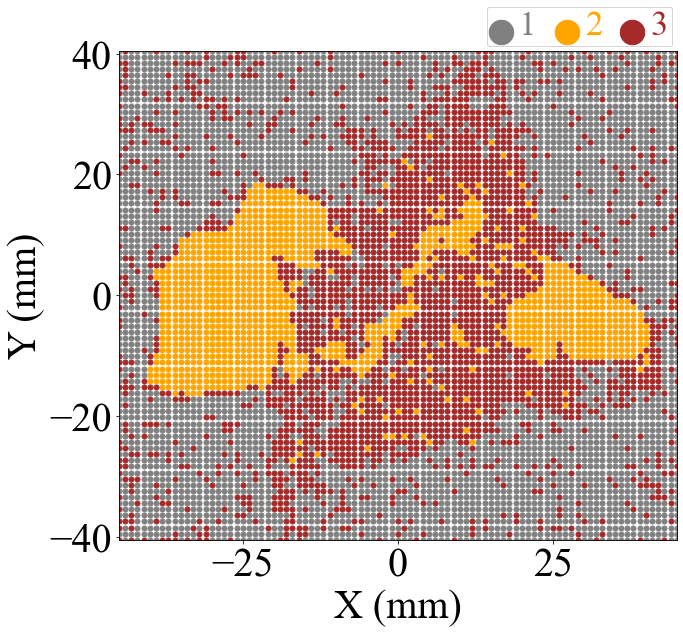

In [46]:
nk=3
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {1: 1, 0: 2, 2: 0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.5471442138108805
Accuracy, Precision, Recall and F1 of Au:  0.739384072717406 0.9749582637729549 0.5565880390755301 0.7086303655392082
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9711029711029711 0.819672131147541 0.9703196347031964 0.8886565603763722
Accuracy, Precision, Recall and F1 of BN:  0.8192918192918193 0.48677248677248675 0.5696594427244582 0.5249643366619116
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.6662596662596663 0.045754328112118714 0.43359375 0.08277404921700224
Accuracy, Precision, Recall and F1 of m-MoS2:  0.9462759462759462 0 0.0 0


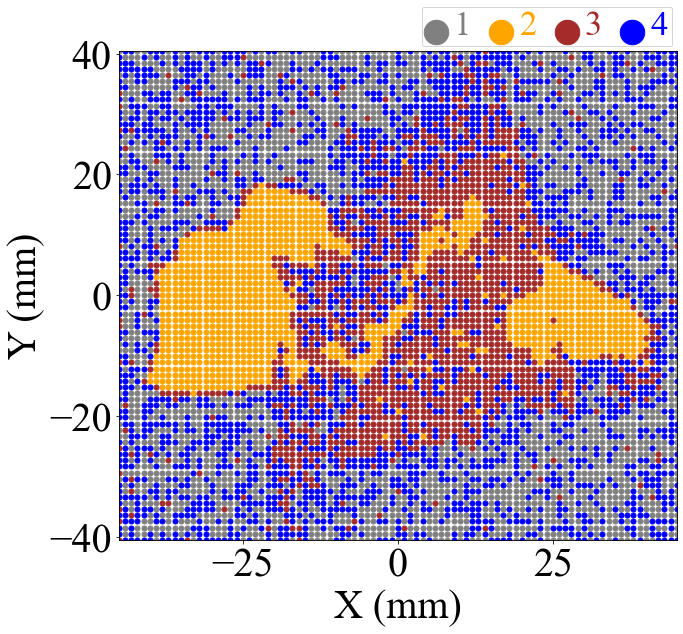

In [47]:
nk=4
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {0: 1, 3: 2, 1: 3, 2:0}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')

Overall Accuracy:  0.4421381088047755
Accuracy, Precision, Recall and F1 of Au:  0.6486229819563153 0.8591864103710326 0.4579461520133429 0.597451041342866
Accuracy, Precision, Recall and F1 of MoS2-Au:  0.9751729751729752 0.8575851393188855 0.9486301369863014 0.9008130081300814
Accuracy, Precision, Recall and F1 of BN:  0.8106091439424773 0.43734939759036146 0.28095975232198145 0.3421300659754949
Accuracy, Precision, Recall and F1 of 1-MoS2:  0.7973137973137974 0.09329829172141918 0.5546875 0.1597300337457818
Accuracy, Precision, Recall and F1 of m-MoS2:  0.7005833672500339 0.0005515719801434088 0.0025252525252525255 0.0009053870529651427


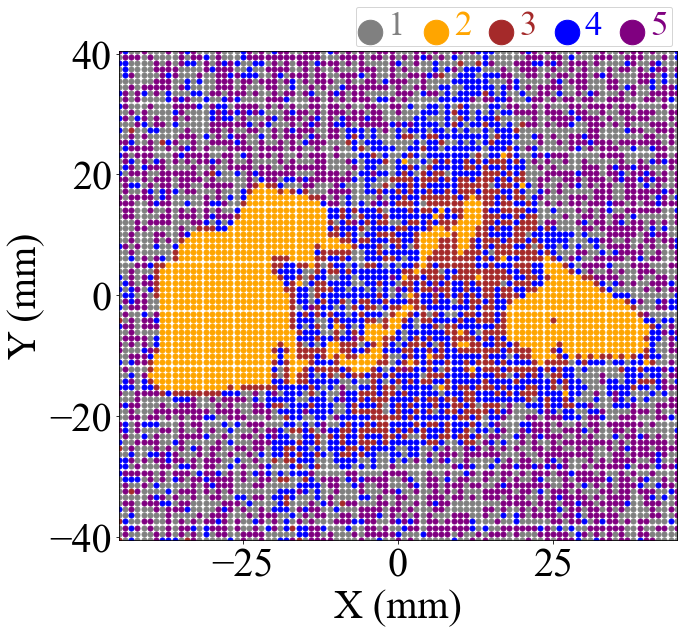

In [48]:
nk=5
km = KMeans(n_clusters=nk, n_init=10, random_state=10)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 
label_mapping = {4:1, 2:4, 0:0, 1:2, 3:3}
km_results = np.array([label_mapping[label] for label in km_results])
calculate_metrics(None,"Accuracy of nk = {}, standard_monoMoS2 as the reference: " , TruthTable, km_results)

fig = clustering_plot(nk, km_results)
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.pdf', dpi=300, bbox_inches='tight')
fig.savefig(f'plots_correlations/clustering_result_standard_monoMoS2_nk{nk}.svg', dpi=300, bbox_inches='tight')